In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import random

# Initial set-up and characteristics of the Bermudean swap
In this section we set the following values:
- Set of dates `T`
- Time interval between each date `tau`
- Fixed rate of the underlying swap `K`
Moreover, we create the following functions which are useful in the implementation of the paths generation:
- `sigma` that computes the volatility as function of k.
- `theta` that computes the value of theta as function of k.
- `d_W` that computes the increment of the Brownian Motion following the given hypothesis (also function of k).
- `rho` that computes the correlation between two increments of BM which are functions of different k. 
 


In [2]:
# Set the vector of the dates

T = np.array([i*0.25 for i in range(17)])

# Strike (fixed rate of the underlying swap)

K = 0.05

# Tau

tau = 0.25

# Volatilities of forward rates F_k

def sigma(k):
    if k == 1:
        sigma = 0
    elif k>=2 and k<=7:
        sigma = 0.2
    elif k>=8 and k<=11:
        sigma = 0.22
    else:
        sigma = 0.24
    return sigma    

# Theta, function of k

def theta(k):
    
    theta = (np.pi/2)* (k - 2)/14
    return theta

# dW function of k

def d_W(k):
    # 2 independent draws from univariate standard normal distr
    x1 = np.random.standard_normal(1)
    x2 = np.random.standard_normal(1)
    d_W = np.cos(theta(k))*x1*np.sqrt(0.25) + np.sin(theta(k))*x2*np.sqrt(0.25)
    return d_W

# function that computes the rho

def rho(j,k):
    rho = np.cos(theta(j) - theta(k))
    return rho


# Implementation that generates one path of Forward rates
In this section we create the function `paths_generator` that is able to generate one path of Forward rates under the LR - Spot measure following the description of slide 6/7, lecture 11.

In [18]:
def paths_generator():
    F = np.zeros((16,16))

    # Set the first row of the matrix equal to the initial term structure
    # which we assume to be flat

    F[0,:] = 0.05
    for k in range(1,16):
        for t in range(1,k+1):
            mu = np.sum([sigma(k+1)*tau*rho(j+1,k+1)*sigma(j+1)*F[t-1,j]/(1+tau*F[t-1,j]) for j in range(t-1,k+1)])
            F[t,k] = F[t-1,k]*np.exp((mu - 0.5 * sigma(k+1)**2)*tau + sigma(k+1) * d_W(k+1))       
    return F     

### Create different paths of Forward rates 

In [19]:
path_list=[]
S_vec=[]
for i in range(1000):
    f = paths_generator()
    path_list.append(f)
    

#### Here we visualize one path of Forward rates. Note that we reproduce what is shown on slide 7 lecture 11, but for our specific example.

In [20]:
pd.DataFrame(path_list[200]).iloc[:9,:]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.05,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000
1,0.00,0.062325,0.056695,0.069591,0.044399,0.045410,0.052386,0.051368,0.044781,0.054391,0.048799,0.050069,0.039891,0.046480,0.045164,0.046023
2,0.00,0.000000,0.048358,0.075180,0.037375,0.041709,0.051658,0.060889,0.039504,0.047890,0.045083,0.050954,0.048953,0.055630,0.047013,0.046626
3,0.00,0.000000,0.000000,0.089668,0.037117,0.041608,0.051418,0.059198,0.036850,0.046114,0.054294,0.054599,0.048549,0.060546,0.051661,0.038492
4,0.00,0.000000,0.000000,0.000000,0.036152,0.043066,0.049801,0.062133,0.036238,0.042583,0.054562,0.053601,0.047919,0.048360,0.046762,0.032441
5,0.00,0.000000,0.000000,0.000000,0.000000,0.046049,0.052707,0.064549,0.036835,0.043784,0.052445,0.051421,0.050563,0.048508,0.066222,0.036184
6,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.064331,0.075900,0.039302,0.045509,0.047629,0.056991,0.048408,0.045469,0.072565,0.036352
7,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.081936,0.040165,0.046491,0.061711,0.047626,0.041434,0.043906,0.070410,0.032745
8,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.036275,0.050991,0.075304,0.058177,0.041206,0.054443,0.080741,0.033073


# Implementation of the Andersen Algorithm
In this section we first create the following functions, useful within the application of the algorithm:
- `P` which computes the 'horizontal' discount factor, that discounts the cashflows that a swaption generates after it is exercised.
- `S` which is the value of the underlying receiver swap if exercised at T_j.
- `D` which computes the value of the stochasitc discount factor using the simulated **spot rates**


In [21]:
# Function for the discount factor (horizontal)

def P(j,k,F):
    P = np.prod([1/(1+tau*F[j,i-1]) for i in range(j+1,k+1)])
    return P

# Compute the value of the underlying swap
def S(j,F):
    S = tau*np.sum([P(j,k,F)*(K - F[j, k-1]) for k in range(j+1, 17)])
    return S

    
# Function for the discount factor (diagonal)
def D(e,F):
    D = np.prod([1/(1 + tau * F[j,j])  for j in range(e)])
    return D


We use the following cell in order to see approximately which H_max we have to select in each level of the iteration within the Andersen Algorithm.

In [39]:
S_vec=[]
for j in range(1000):
    S_vec.append(S(4,path_list[j])) # 
upperbound=np.max(S_vec)
upperbound

0.027475390451005516

### Here we begin the algorithm
In particular, we proceed as follows:
1. we start from computing the optimal exercise strategy as if we would have only the **last two** exercise dates. Then we save the first optimal threshold `H7`
2. we compute the optimal exercise strategy as if we would have only **the last three** exercise dates, using also the optimal threshold we found in the previous point `H7`. We save the second optimal threshold `H6`  
3. we repeat the same backward procedure, up to the point when we consider to have four exercise dates (which is the characteristic of our Bermudean swaption)
4. at the end we have all the optimal thresholds (`H7`,`H6`,`H5`,`H4`) which mazimize the value of our exercise strategy.

Note that at the end of each step where we compute the new optimal threshold we also illustrate, through a plot, the value of the exercise strategy as function of the threshold. 

In [23]:
H1 = np.linspace(0,0.05,100) 

prices = []
for h in tqdm.tqdm(H1):
    V0 = []
    for i in range(1000):
        F = path_list[i] 
        V0.append( D(7,F) * S(7,F) * (S(7,F) > h) +  D(8,F)* S(8,F) * ( S(7,F) <= h ) * ( S(8,F) > 0 ) )
    prices.append(np.mean(V0))
    



100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.57it/s]


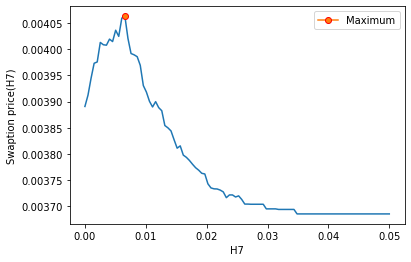

In [24]:
plt.plot(H1, prices)
np.where(H1 == np.max(prices))
index = np.where(prices == np.max(prices))
H7 = H1[index]
p = np.array(prices)[index]
plt.xlabel('H7')
plt.ylabel('Swaption price(H7)')
plt.plot(H7,p , marker="o", markeredgecolor="red",label ='Maximum')
plt.legend()
plt.show()

In [25]:
H1 = np.linspace(0,0.035,100) 

prices = []
for h in tqdm.tqdm(H1):
    V0 = []
    for i in range(1000):
        F = path_list[i] 
        V0.append( D(6,F)*S(6,F)*(S(6,F)>h) + (D(7,F) * S(7,F) * (S(7,F) > H7)*(S(6,F)<=h) +  D(8,F)* S(8,F) * (S(6,F)<= h)* ( S(7,F) <= H7 ) * ( S(8,F) > 0 ) ))
    prices.append(np.mean(V0))
    



100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:13<00:00,  1.36it/s]


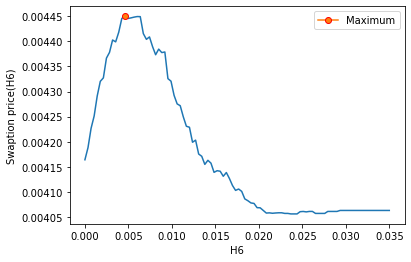

In [26]:
plt.plot(H1, prices)
index = np.where(prices == np.max(prices))
H6 = H1[index]
p = np.array(prices)[index]
plt.xlabel('H6')
plt.ylabel('Swaption price(H6)')
plt.plot(H6,p , marker="o", markeredgecolor="red",label ='Maximum')
plt.legend()
plt.show()

In [27]:
H1 = np.linspace(0,0.035,100) 

prices = []
for h in tqdm.tqdm(H1):
    V0 = []
    for i in range(1000):
        F = path_list[i] 
        V0.append( D(5,F)*S(5,F)*(S(5,F)>h)+ D(6,F)*S(6,F)*(S(6,F)>H6)*((S(5,F)<=h)) + (D(7,F) * S(7,F) * (S(7,F) > H7)*(S(6,F)<=H6)*(S(5,F)<=h) +  D(8,F)* S(8,F) *(S(5,F)<=h)* (S(6,F)<= H6)* ( S(7,F) <= H7 ) * ( S(8,F) > 0 ) ))
    prices.append(np.mean(V0))
    


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:04<00:00,  1.24s/it]


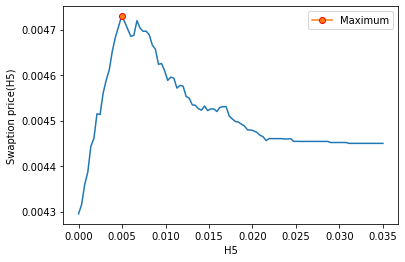

In [28]:
plt.plot(H1, prices)
index = np.where(prices == np.max(prices))
H5 = H1[index]
p = np.array(prices)[index]
plt.xlabel('H5')
plt.ylabel('Swaption price(H5)')
plt.plot(H5,p , marker="o", markeredgecolor="red",label ='Maximum')
plt.legend()
plt.show()

In [29]:
H1 = np.linspace(0,0.03,100) 

prices = []
for h in tqdm.tqdm(H1):
    V0 = []
    for i in range(1000):
        F = path_list[i] 
        V0.append( D(4,F)*S(4,F)*(S(4,F)>h) + D(5,F) * S(5,F) * (S(5,F) > H5)*(S(4,F)<=h) +  D(6,F)* S(6,F) *(S(6,F) > H6) * ( S(5,F) <= H5 ) * (S(4,F)<= h) + D(7,F) * S(7,F) * ( S(7,F) > H7 )*(S(6,F) <= H6)*(S(5,F) <= H5) * (S(4,F) <= h) + D(8,F) * (S(8,F)) * (S(8,F)>0)*(S(7,F) <= H7)*(S(6,F) <= H6)* (S(5,F) <= H5) * (S(4,F) <= h) )
    prices.append(np.mean(V0))


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:16<00:00,  1.96s/it]


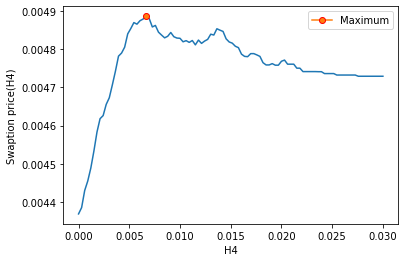

In [30]:
plt.plot(H1, prices)
index = np.where(prices == np.max(prices))
H4 = H1[index]
p = np.array(prices)[index]
plt.xlabel('H4')
plt.ylabel('Swaption price(H4)')
plt.plot(H4,p , marker="o", markeredgecolor="red",label ='Maximum')
plt.legend()
plt.show()

## We repeat the simulation of Forward rates and we use the optimal exercise strategy that we derived before to price the receiver Bermudean swaption

In [31]:
#second simulation of 1000 paths to price the Bermudean
path_2=[]
for i in range(1000):
    f = paths_generator()
    path_2.append(f)
    

In [32]:
V0 = []
for i in range(1000):
    F = path_2[i] 
    V0.append( D(4,F)*S(4,F)*(S(4,F)>H4) + D(5,F) * S(5,F) * (S(5,F) > H5)*(S(4,F)<=H4) +  D(6,F)* S(6,F) *(S(6,F) > H6) * ( S(5,F) <= H5 ) * (S(4,F)<= H4) + D(7,F) * S(7,F) * ( S(7,F) > H7 )*(S(6,F) <= H6)*(S(5,F) <= H5) * (S(4,F) <= H4) + D(8,F) * (S(8,F)) * (S(8,F)>0)*(S(7,F) <= H7)*(S(6,F) <= H6)* (S(5,F) <= H5) * (S(4,F) <= H4) )
final_price = (np.mean(V0))
final_price
print("Price of the receiver Bermudean swaption:", final_price)

Price of the receiver Bermudean swaption: 0.004618781102910455
